In [48]:
# Imports here
import torch
import PIL
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torchvision import datasets, transforms, models
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F
from torch import optim
from collections import OrderedDict
from time import time
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np
import skimage.io as io
import os
import copy
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [49]:

data_dir = '/kaggle/input/eurosat-dataset'
train_dir = data_dir + '/EuroSAT'

# Define your transformations
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load all the images from the train folder
all_data = datasets.ImageFolder(train_dir, transform=train_transforms)

# Calculate the sizes for train, validation, and test sets
total_size = len(all_data)
train_size = int(0.7 * total_size)
test_size = int(0.15 * total_size)
valid_size = total_size - train_size - test_size

# Use random_split to split the dataset
train_data, valid_data, test_data = torch.utils.data.random_split(all_data, [train_size, valid_size, test_size])

# Create data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=50, shuffle=False)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=50)
testloader = torch.utils.data.DataLoader(test_data, batch_size=50)


In [78]:
# Load a pre-trained network 
model = models.squeezenet1_0(pretrained=True) 
model.name = "squeezeNet"
model

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [79]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

In [80]:
# classifier = nn.Sequential(OrderedDict([
#                           ('fc1', nn.Linear(9216, 4096, bias=True)),
#                           ('relu1', nn.ReLU()),
#                           ('dropout1', nn.Dropout(p=0.5)),
#                           ('fc2', nn.Linear(4096, 10, bias=True)),
#                           ('output', nn.LogSoftmax(dim=1)) # Use nn.Softmax if Loss is CrossEntropy
#                           ]))
    
# model.classifier = classifier

In [90]:
classifier = nn.Sequential(
    nn.Dropout(p=0.5),  # Dropout before the final linear layer
    nn.Conv2d(512, 10, kernel_size=1),  # 1x1 convolution for final classification
    nn.ReLU(),  # ReLU activation for non-linearity
    nn.AdaptiveAvgPool2d(1),  # Global average pooling
    nn.Flatten(),  # Flatten output for final linear layer
    nn.LogSoftmax(dim=1)  # LogSoftmax for probability distribution
)

# Replace the original classifier with your new one
model.classifier = classifier

In [91]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [92]:
!pip install torchsummary

In [93]:
def count_parameters(model):
    """Counts the total number of trainable and non-trainable parameters in a model."""
    total_params = {'trainable': 0, 'non-trainable': 0}
    for name, param in model.named_parameters():
        if not param.requires_grad:
            total_params['non-trainable'] += param.numel()
        else:
            total_params['trainable'] += param.numel()
    return total_params

In [94]:
param_counts = count_parameters(model)

print(f"Trainable Parameters: {param_counts['trainable']}")
print(f"Non-Trainable Parameters: {param_counts['non-trainable']}")
print(f"Total Parameters: {param_counts['trainable'] + param_counts['non-trainable']}")

Trainable Parameters: 5130
Non-Trainable Parameters: 735424
Total Parameters: 740554


In [95]:
# change to device
model.to(device)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [96]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Define deep learning method
epochs = 5
print_every = 30 # Prints every 30 images out of batch of 50 images
steps = 0

In [97]:
# Implement a function for the validation pass
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    
    for ii, (inputs, labels) in enumerate(testloader):
        
        # Uncomment below line if gpu is available
        inputs, labels = inputs.to(device), labels.to(device)
        
        output = model.forward(inputs)
        test_loss += criterion(output, labels).item()
        
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [98]:
def train(model,steps,print_every,epochs):
    print("Training process initializing .....\n")

    for e in range(epochs):
        running_loss = 0
        model.train() 
    
        for ii, (inputs, labels) in enumerate(trainloader):
            steps += 1
        
            inputs, labels = inputs.to(device), labels.to(device)
        
            optimizer.zero_grad()
        
            # Forward and backward passes
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item()
        
            if steps % print_every == 0:
                model.eval()

                with torch.no_grad():
                    valid_loss, accuracy = validation(model, validloader, criterion)
            
                print("Epoch: {}/{} | ".format(e+1, epochs),
                      "Training Loss: {:.4f} | ".format(running_loss/print_every),
                      "Validation Loss: {:.4f} | ".format(valid_loss/len(validloader)),
                      "Validation Accuracy: {:.4f}".format(accuracy/len(validloader)))
            
                running_loss = 0
                model.train()

    print("\nTraining process is now complete!!")
    return model

In [99]:
model = train(model,steps,print_every,epochs)

Training process initializing .....

Epoch: 1/5 |  Training Loss: 1.7547 |  Validation Loss: 1.2478 |  Validation Accuracy: 0.6294
Epoch: 1/5 |  Training Loss: 1.0527 |  Validation Loss: 0.8632 |  Validation Accuracy: 0.7269
Epoch: 1/5 |  Training Loss: 0.8474 |  Validation Loss: 0.7937 |  Validation Accuracy: 0.7388
Epoch: 1/5 |  Training Loss: 0.7177 |  Validation Loss: 0.6811 |  Validation Accuracy: 0.7822
Epoch: 1/5 |  Training Loss: 0.6800 |  Validation Loss: 0.6807 |  Validation Accuracy: 0.7672
Epoch: 1/5 |  Training Loss: 0.6618 |  Validation Loss: 0.6368 |  Validation Accuracy: 0.7864
Epoch: 1/5 |  Training Loss: 0.6289 |  Validation Loss: 0.6037 |  Validation Accuracy: 0.8020
Epoch: 1/5 |  Training Loss: 0.6178 |  Validation Loss: 0.5619 |  Validation Accuracy: 0.8173
Epoch: 1/5 |  Training Loss: 0.5646 |  Validation Loss: 0.5797 |  Validation Accuracy: 0.8072
Epoch: 1/5 |  Training Loss: 0.5405 |  Validation Loss: 0.5544 |  Validation Accuracy: 0.8153
Epoch: 1/5 |  Training 

In [100]:
def pred(Model,Testloader):
    all_labels = []
    all_predictions = []
    correct = 0
    total = 0
    start_time = time()
    with torch.no_grad():
        Model.eval()
        for images, labels in Testloader:
            all_labels.extend(labels.numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = Model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_tensor_cpu = predicted.to('cpu')
            all_predictions.extend(predicted_tensor_cpu.numpy())
    end_time = time()
    print("Time: ",end_time - start_time)
    print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct / total))
    
    return all_labels,all_predictions

In [101]:
labels,predictions = pred(model,testloader)

Time:  44.22631120681763
Accuracy achieved by the network on test images is: 85%


In [102]:
def metrics(labels,predictions):
    classes = train_data.dataset.classes
    cm = confusion_matrix(np.array(labels), np.array(predictions))
    print("Confusion Matrix:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    print('----------------------------------------------------------------')
    print("Classification Report:")
    report = classification_report(np.array(labels),np.array(predictions))
    print(report)

Confusion Matrix:


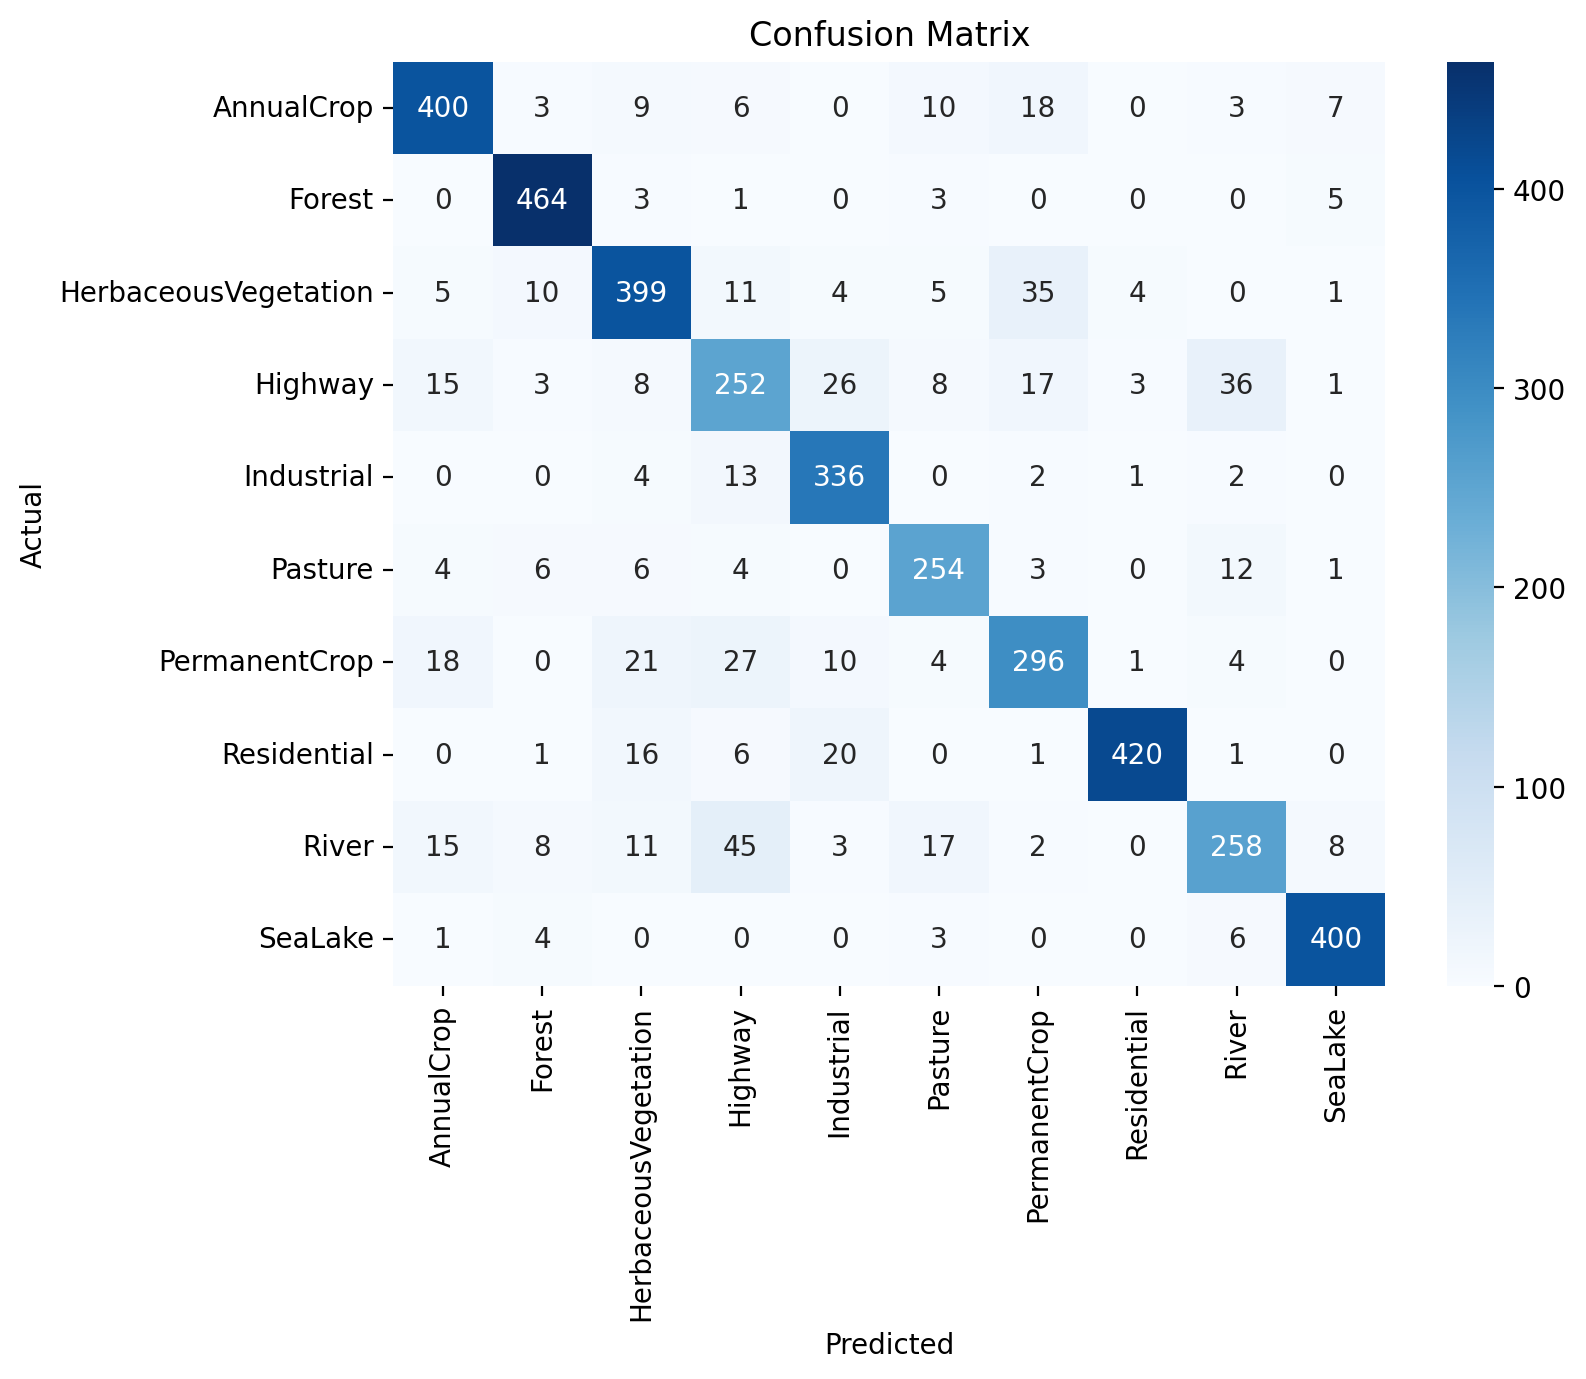

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       456
           1       0.93      0.97      0.95       476
           2       0.84      0.84      0.84       474
           3       0.69      0.68      0.69       369
           4       0.84      0.94      0.89       358
           5       0.84      0.88      0.86       290
           6       0.79      0.78      0.78       381
           7       0.98      0.90      0.94       465
           8       0.80      0.70      0.75       367
           9       0.95      0.97      0.96       414

    accuracy                           0.86      4050
   macro avg       0.85      0.85      0.85      4050
weighted avg       0.86      0.86      0.86      4050



In [103]:
metrics(labels,predictions)

# QUANTIZATION

In [104]:
model_fp16 = copy.deepcopy(model)

In [105]:
model_fp16.half()

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [106]:
weights_half = model_fp16.state_dict()
print(weights_half['features.0.weight'].dtype)

torch.float16


In [107]:
model_fp16.to(device)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [108]:
def pred_fp16(Model,Testloader):
    all_labels = []
    all_predictions = []
    correct = 0
    total = 0
    start_time = time()
    with torch.no_grad():
        Model.eval()
        for images, labels in Testloader:
            all_labels.extend(labels.numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = Model(images.half())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_tensor_cpu = predicted.to('cpu')
            all_predictions.extend(predicted_tensor_cpu.numpy())
    end_time = time()
    print("Time: ",end_time - start_time)
    print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct / total))
    
    return all_labels,all_predictions

In [109]:
labels,predictions = pred_fp16(model_fp16,testloader)

Time:  14.259974956512451
Accuracy achieved by the network on test images is: 86%


Confusion Matrix:


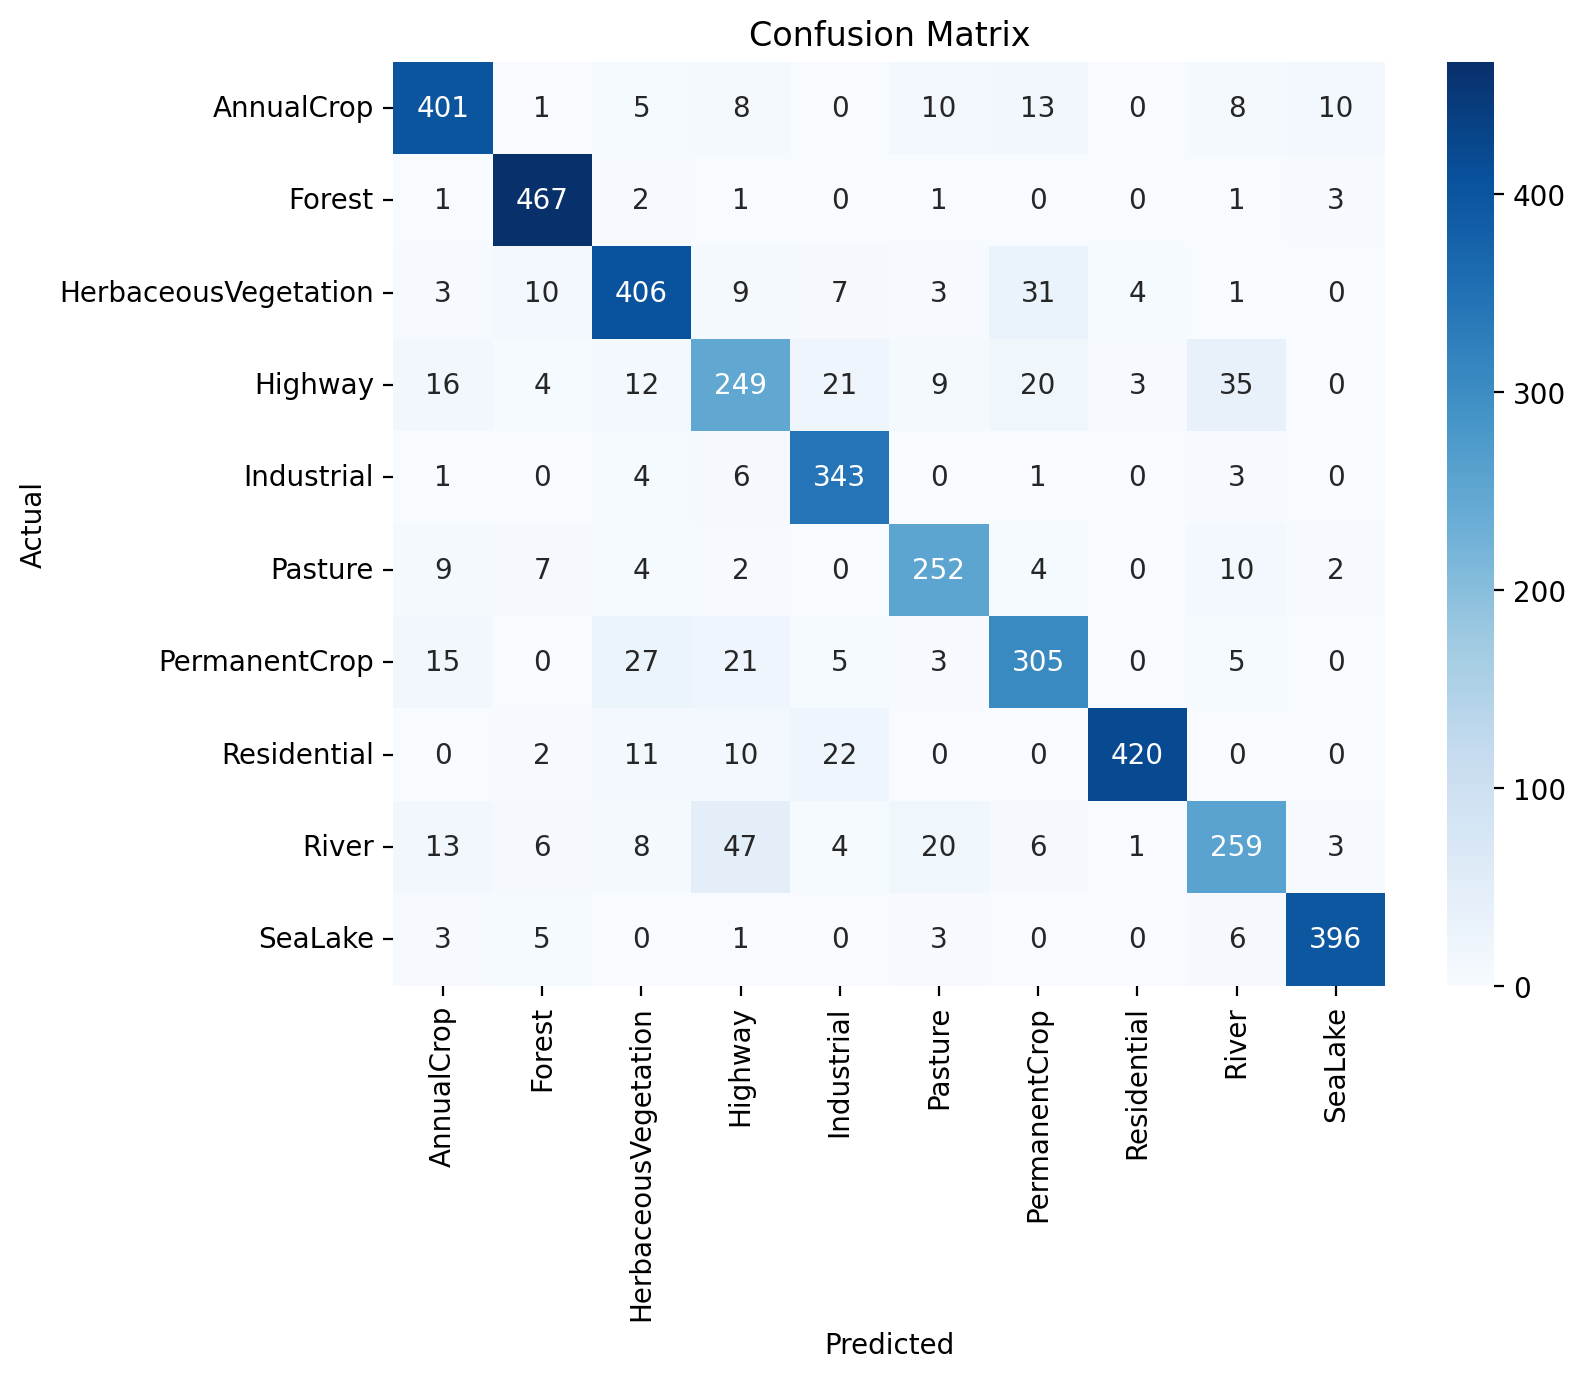

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87       456
           1       0.93      0.98      0.96       476
           2       0.85      0.86      0.85       474
           3       0.70      0.67      0.69       369
           4       0.85      0.96      0.90       358
           5       0.84      0.87      0.85       290
           6       0.80      0.80      0.80       381
           7       0.98      0.90      0.94       465
           8       0.79      0.71      0.75       367
           9       0.96      0.96      0.96       414

    accuracy                           0.86      4050
   macro avg       0.86      0.86      0.86      4050
weighted avg       0.86      0.86      0.86      4050



In [110]:
metrics(labels,predictions)

# FP-64

In [111]:
model_64 = copy.deepcopy(model)
model_64.double()

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [112]:
weights_64 = model_64.state_dict()
print(weights_64['features.0.weight'].dtype)

torch.float64


In [113]:
model_64.to(device)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [114]:
def pred_fp64(Model,Testloader):
    all_labels = []
    all_predictions = []
    correct = 0
    total = 0
    start_time = time()
    with torch.no_grad():
        Model.eval()
        for images, labels in Testloader:
            all_labels.extend(labels.numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = Model(images.double())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_tensor_cpu = predicted.to('cpu')
            all_predictions.extend(predicted_tensor_cpu.numpy())
    end_time = time()
    print("Time: ",end_time - start_time)
    print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct / total))
    
    return all_labels,all_predictions

In [115]:
 labels,predictions = pred_fp64(model_64,testloader)

Time:  45.47315192222595
Accuracy achieved by the network on test images is: 85%


Confusion Matrix:


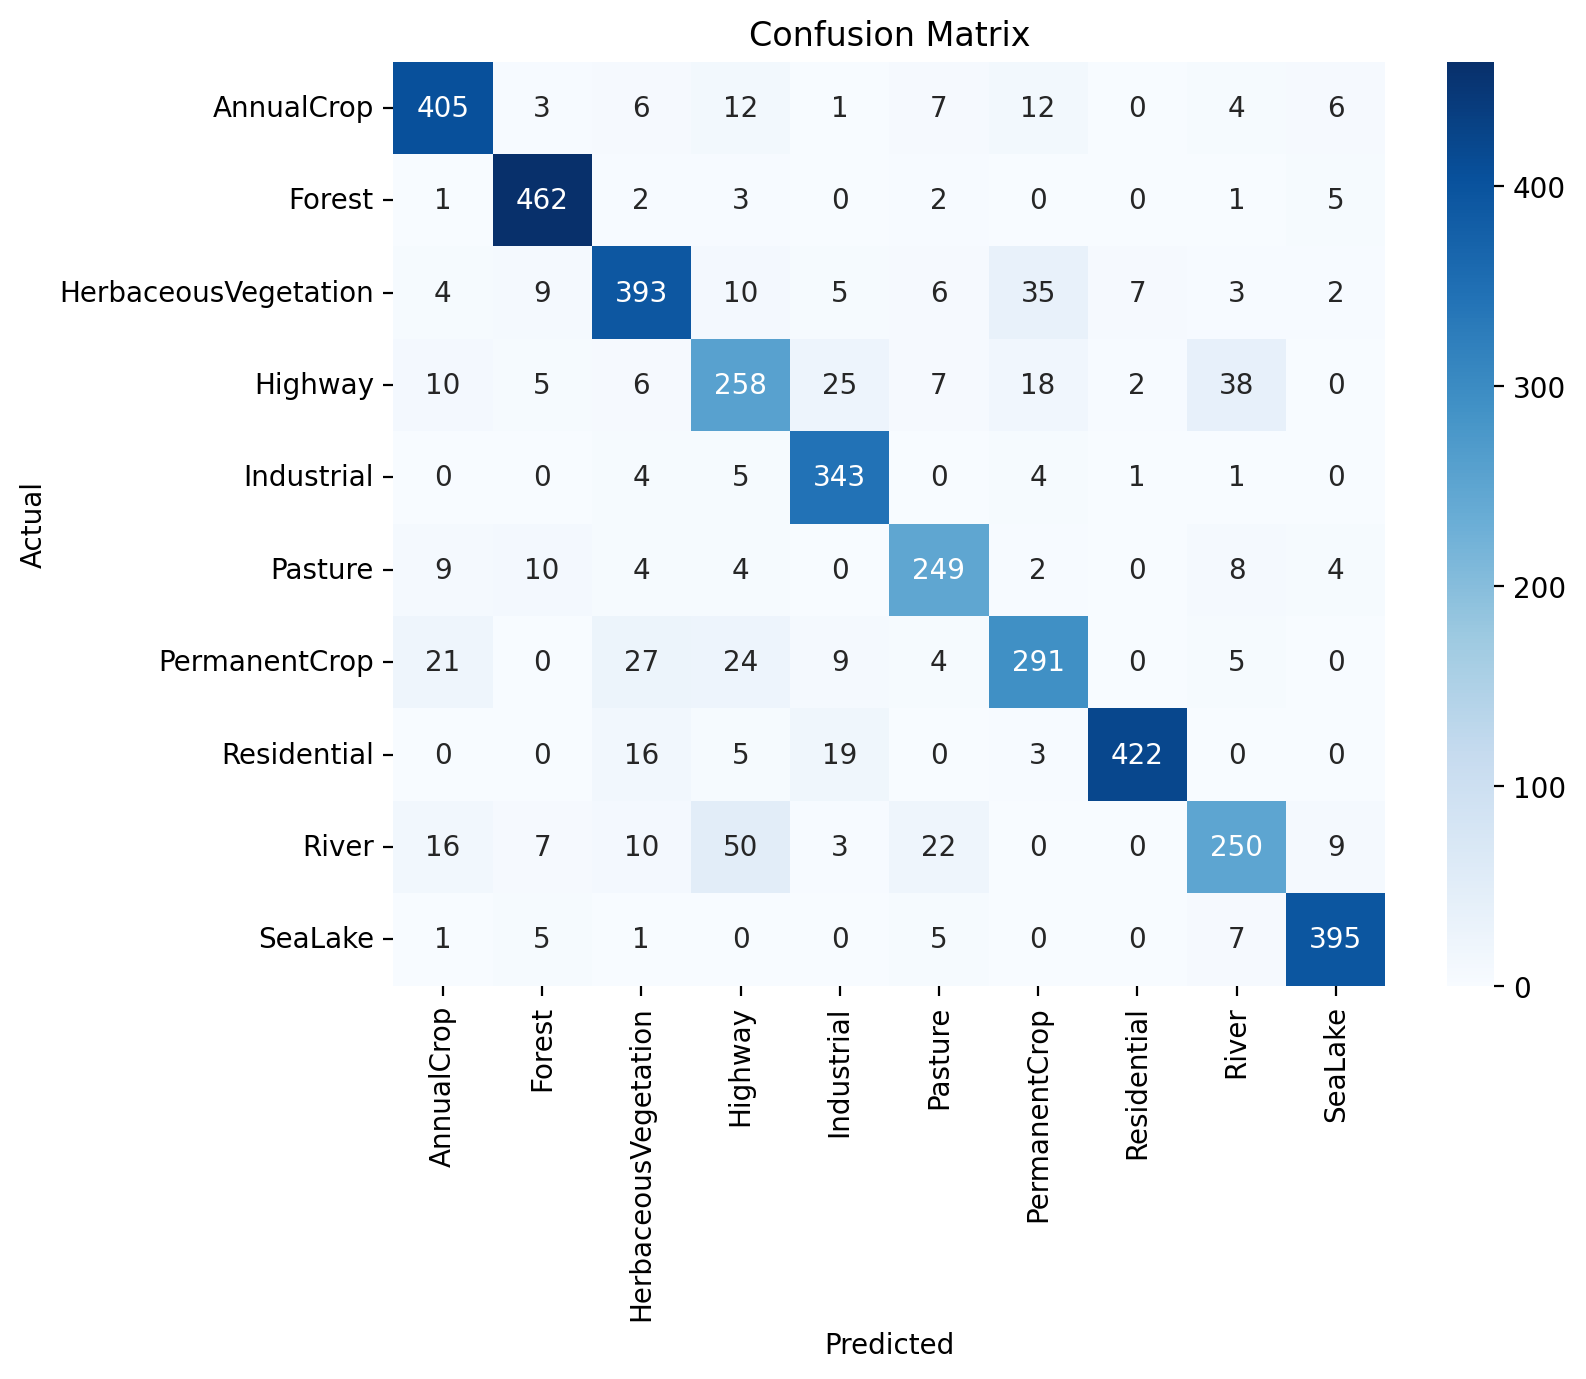

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       456
           1       0.92      0.97      0.95       476
           2       0.84      0.83      0.83       474
           3       0.70      0.70      0.70       369
           4       0.85      0.96      0.90       358
           5       0.82      0.86      0.84       290
           6       0.80      0.76      0.78       381
           7       0.98      0.91      0.94       465
           8       0.79      0.68      0.73       367
           9       0.94      0.95      0.95       414

    accuracy                           0.86      4050
   macro avg       0.85      0.85      0.85      4050
weighted avg       0.86      0.86      0.86      4050



In [116]:
metrics(labels,predictions)

## INT-8

In [117]:
from torch.ao.quantization import QuantStub, DeQuantStub
import torch
from torch.ao.quantization import (
  get_default_qconfig_mapping,
  get_default_qat_qconfig_mapping,
  QConfigMapping,
)
import torch.ao.quantization.quantize_fx as quantize_fx

### PTQ

In [118]:
model_fp32 = copy.deepcopy(model)

In [119]:
model_fp32.to('cpu')

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [120]:
input_data = next(iter(trainloader))[0]
calibrate_data = input_data.to("cpu")

In [121]:
model_int8 = copy.deepcopy(model_fp32)
#model_int8.to(device)
qconfig_mapping = get_default_qconfig_mapping("qnnpack")
model_int8.eval()
# prepare
model_prepared = quantize_fx.prepare_fx(model_int8, qconfig_mapping, calibrate_data)
# calibrate 

/opt/conda/lib/python3.10/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/opt/conda/lib/python3.10/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/opt/conda/lib/python3.10/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/opt/conda/lib/python3.10/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


In [122]:
with torch.no_grad():
    for i in range(20):
        batch = next(iter(trainloader))[0]
        output = model_prepared(batch.to('cpu'))

In [123]:
model_quantized_static = quantize_fx.convert_fx(model_prepared)

In [124]:
model_quantized_static.to('cpu')

GraphModule(
  (features): Module(
    (0): QuantizedConvReLU2d(3, 96, kernel_size=(7, 7), stride=(2, 2), scale=0.041064292192459106, zero_point=0)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Module(
      (squeeze): QuantizedConvReLU2d(96, 16, kernel_size=(1, 1), stride=(1, 1), scale=0.10222657024860382, zero_point=0)
      (expand1x1): QuantizedConvReLU2d(16, 64, kernel_size=(1, 1), stride=(1, 1), scale=0.058437395840883255, zero_point=0)
      (expand3x3): QuantizedConvReLU2d(16, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.058437395840883255, zero_point=0, padding=(1, 1))
    )
    (4): Module(
      (squeeze): QuantizedConvReLU2d(128, 16, kernel_size=(1, 1), stride=(1, 1), scale=0.20095720887184143, zero_point=0)
      (expand1x1): QuantizedConvReLU2d(16, 64, kernel_size=(1, 1), stride=(1, 1), scale=0.14317183196544647, zero_point=0)
      (expand3x3): QuantizedConvReLU2d(16, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.143171831

In [125]:
all_labels_int8 = []
all_predictions_int8 = []
correct_pred = 0
total_pred = 0
start_time_int8 = time()
with torch.no_grad():
    model_quantized_static.eval()
    for data in testloader:
        images, labels = data
        all_labels_int8.extend(labels.numpy())
        #images, labels = images.to(device), labels.to(device)
        outputs = model_quantized_static(images.to('cpu'))
        _, predicted = torch.max(outputs.data, 1)
        total_pred += labels.size(0)
        correct_pred += (predicted == labels).sum().item()
        predicted_tensor_cpu = predicted.to('cpu')
        all_predictions_int8.extend(predicted_tensor_cpu.numpy())
end_time_int8 = time()
print("Time: ",end_time_int8 - start_time_int8)

print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct_pred / total_pred))

Time:  48.99554443359375
Accuracy achieved by the network on test images is: 81%


Confusion Matrix:


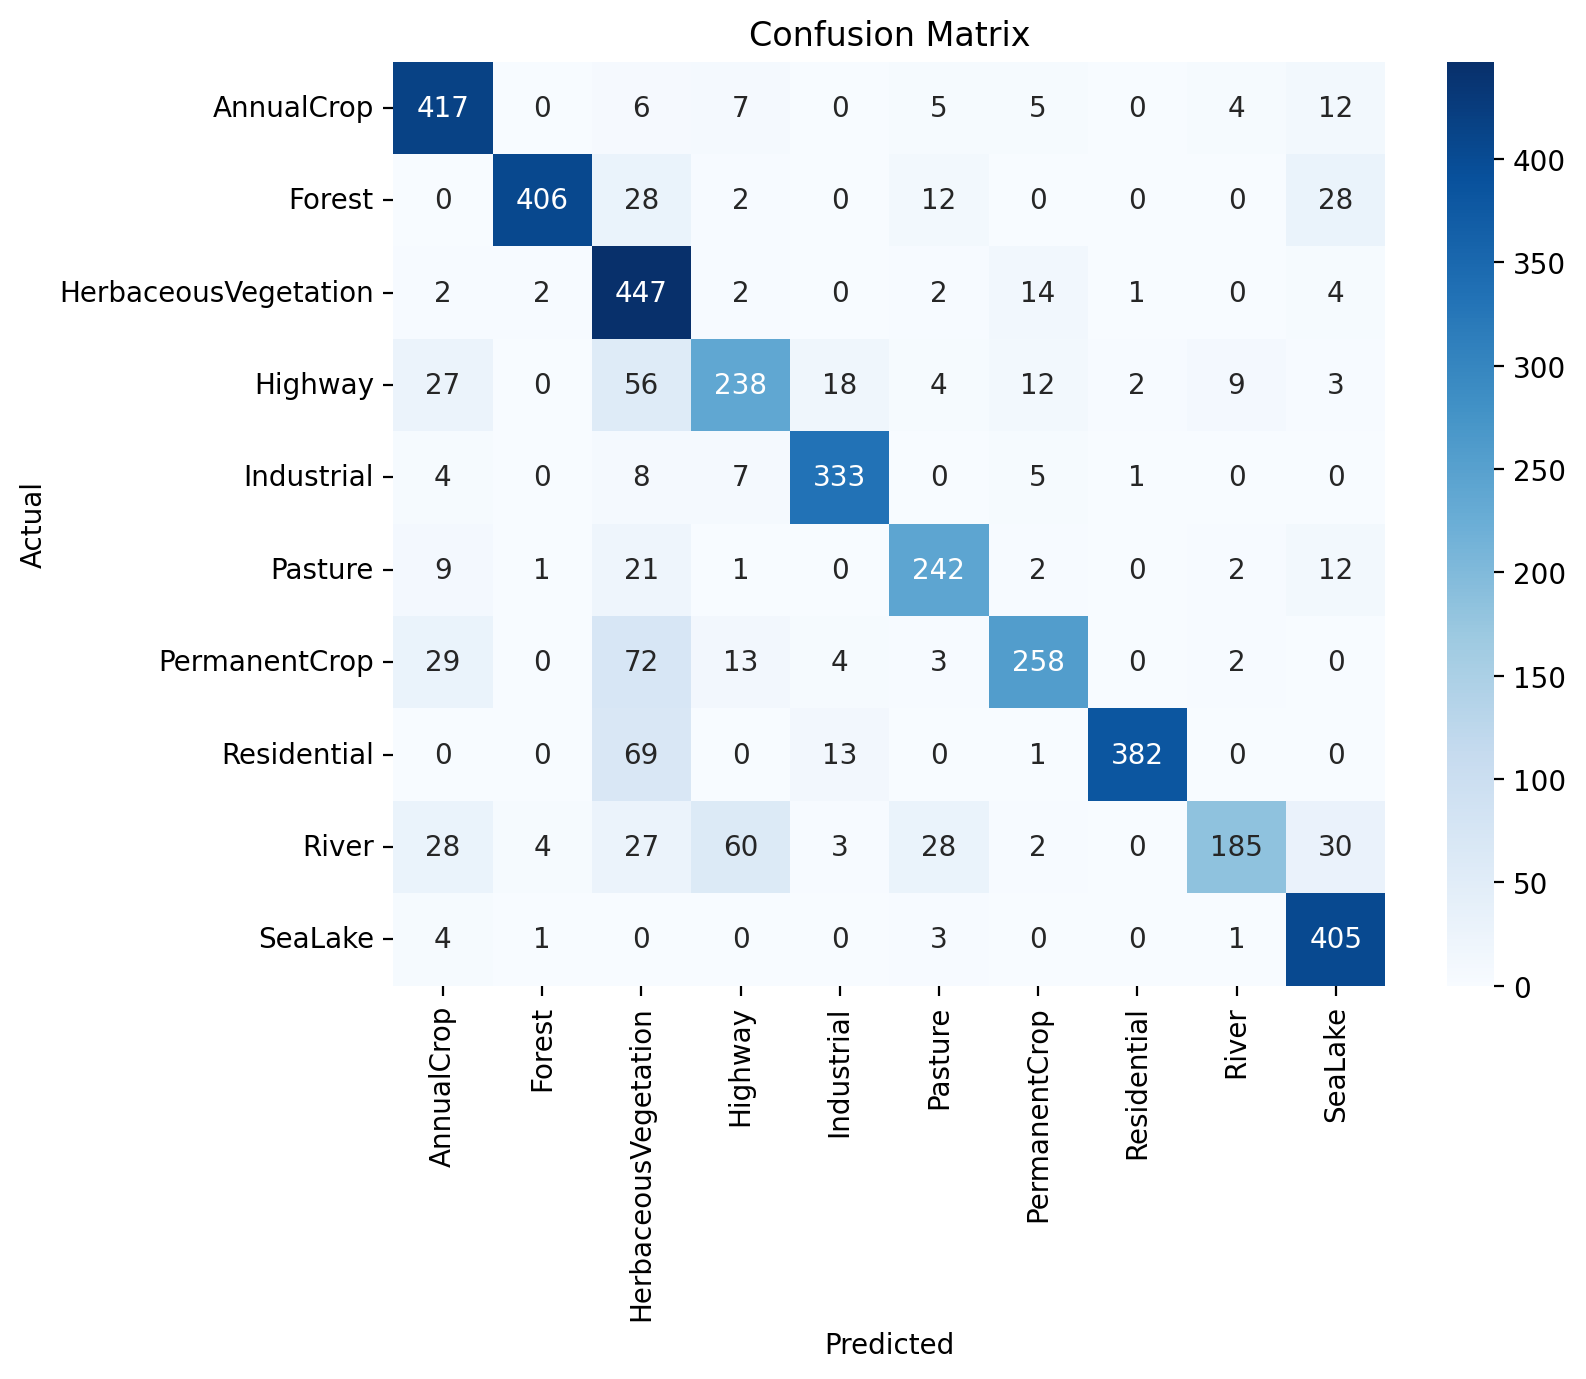

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       456
           1       0.98      0.85      0.91       476
           2       0.61      0.94      0.74       474
           3       0.72      0.64      0.68       369
           4       0.90      0.93      0.91       358
           5       0.81      0.83      0.82       290
           6       0.86      0.68      0.76       381
           7       0.99      0.82      0.90       465
           8       0.91      0.50      0.65       367
           9       0.82      0.98      0.89       414

    accuracy                           0.82      4050
   macro avg       0.84      0.81      0.81      4050
weighted avg       0.84      0.82      0.82      4050



In [126]:
metrics(all_labels_int8,all_predictions_int8)

# QAT

In [127]:
input_data = next(iter(trainloader))[0]
calibrate_data = input_data.to(device)

In [128]:
model.eval()
model.qconfig = torch.ao.quantization.get_default_qat_qconfig('x86')
model.train()

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [129]:
qconfig_mapping = get_default_qat_qconfig_mapping("x86")
model_prepared = quantize_fx.prepare_qat_fx(model, qconfig_mapping, calibrate_data)

/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [130]:
model_prepared.to(device)

GraphModule(
  (activation_post_process_0): FusedMovingAvgObsFakeQuantize(
    fake_quant_enabled=tensor([1], device='cuda:0'), observer_enabled=tensor([1], device='cuda:0'), scale=tensor([1.], device='cuda:0'), zero_point=tensor([0], device='cuda:0', dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
    (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
  )
  (features): Module(
    (0): ConvReLU2d(
      3, 96, kernel_size=(7, 7), stride=(2, 2)
      (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
        fake_quant_enabled=tensor([1], device='cuda:0'), observer_enabled=tensor([1], device='cuda:0'), scale=tensor([1.], device='cuda:0'), zero_point=tensor([0], device='cuda:0', dtype=torch.int32), dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_channel_symmetric, reduce_range=False
        (activation_post_process): MovingAveragePerChannelMinMaxObserver(min_val=ten

In [131]:
model_prepared = train(model_prepared,steps,print_every,epochs)

Training process initializing .....



/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/fake_quantize.py:343: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/ReduceAllOps.cpp:72.)
  return torch.fused_moving_avg_obs_fake_quant(
/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/fake_quantize.py:343: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorCompare.cpp:677.)
  return torch.fused_moving_avg_obs_fake_quant(


Epoch: 1/5 |  Training Loss: 0.6917 |  Validation Loss: 0.5544 |  Validation Accuracy: 0.8059
Epoch: 1/5 |  Training Loss: 0.5319 |  Validation Loss: 0.5229 |  Validation Accuracy: 0.8188
Epoch: 1/5 |  Training Loss: 0.5295 |  Validation Loss: 0.5269 |  Validation Accuracy: 0.8207
Epoch: 1/5 |  Training Loss: 0.5072 |  Validation Loss: 0.4766 |  Validation Accuracy: 0.8346
Epoch: 1/5 |  Training Loss: 0.4832 |  Validation Loss: 0.5241 |  Validation Accuracy: 0.8156
Epoch: 1/5 |  Training Loss: 0.4906 |  Validation Loss: 0.4961 |  Validation Accuracy: 0.8272
Epoch: 1/5 |  Training Loss: 0.5242 |  Validation Loss: 0.4763 |  Validation Accuracy: 0.8309
Epoch: 1/5 |  Training Loss: 0.5153 |  Validation Loss: 0.4815 |  Validation Accuracy: 0.8358
Epoch: 1/5 |  Training Loss: 0.4593 |  Validation Loss: 0.4651 |  Validation Accuracy: 0.8375
Epoch: 1/5 |  Training Loss: 0.4836 |  Validation Loss: 0.4886 |  Validation Accuracy: 0.8353
Epoch: 1/5 |  Training Loss: 0.4528 |  Validation Loss: 0.45

In [132]:
model_prepared.to('cpu')

GraphModule(
  (activation_post_process_0): FusedMovingAvgObsFakeQuantize(
    fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([0.0375]), zero_point=tensor([57], dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
    (activation_post_process): MovingAverageMinMaxObserver(min_val=-2.1179039478302, max_val=2.6399881839752197)
  )
  (features): Module(
    (0): ConvReLU2d(
      3, 96, kernel_size=(7, 7), stride=(2, 2)
      (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
        fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([0.0030, 0.0021, 0.0062, 0.0016, 0.0021, 0.0047, 0.0010, 0.0028, 0.0048,
                0.0032, 0.0012, 0.0009, 0.0015, 0.0010, 0.0027, 0.0013, 0.0016, 0.0016,
                0.0015, 0.0057, 0.0008, 0.0020, 0.0036, 0.0056, 0.0048, 0.0021, 0.0029,
                0.0034, 0.0025, 0.0057, 0.0013, 0.0017, 0.0031, 0.0012, 0.0011, 0.0014,
       

In [133]:
model_quantized_trained = quantize_fx.convert_fx(model_prepared)

In [134]:
model_quantized_trained.to('cpu')

GraphModule(
  (features): Module(
    (0): QuantizedConvReLU2d(3, 96, kernel_size=(7, 7), stride=(2, 2), scale=0.14963079988956451, zero_point=0)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Module(
      (squeeze): QuantizedConvReLU2d(96, 16, kernel_size=(1, 1), stride=(1, 1), scale=0.25723516941070557, zero_point=0)
      (expand1x1): QuantizedConvReLU2d(16, 64, kernel_size=(1, 1), stride=(1, 1), scale=0.1687667816877365, zero_point=0)
      (expand3x3): QuantizedConvReLU2d(16, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.1687667816877365, zero_point=0, padding=(1, 1))
    )
    (4): Module(
      (squeeze): QuantizedConvReLU2d(128, 16, kernel_size=(1, 1), stride=(1, 1), scale=0.46799159049987793, zero_point=0)
      (expand1x1): QuantizedConvReLU2d(16, 64, kernel_size=(1, 1), stride=(1, 1), scale=0.3910783529281616, zero_point=0)
      (expand3x3): QuantizedConvReLU2d(16, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.391078352928161

In [135]:
all_predictions_int8 = []
all_labels_int8 = []
correct_pred = 0
total_pred = 0
start_time_int8 = time()
with torch.no_grad():
    model_quantized_trained.eval()
    for data in testloader:
        images, labels = data
        all_labels_int8.extend(labels.numpy())
        #images, labels = images.to(device), labels.to(device)
        outputs = model_quantized_trained(images.to('cpu'))
        _, predicted = torch.max(outputs.data, 1)
        total_pred += labels.size(0)
        correct_pred += (predicted == labels).sum().item()
        predicted_tensor_cpu = predicted.to('cpu')
        all_predictions_int8.extend(predicted_tensor_cpu.numpy())
end_time_int8 = time()
print("Time: ",end_time_int8 - start_time_int8)
print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct_pred / total_pred))

Time:  56.68227553367615
Accuracy achieved by the network on test images is: 83%


Confusion Matrix:


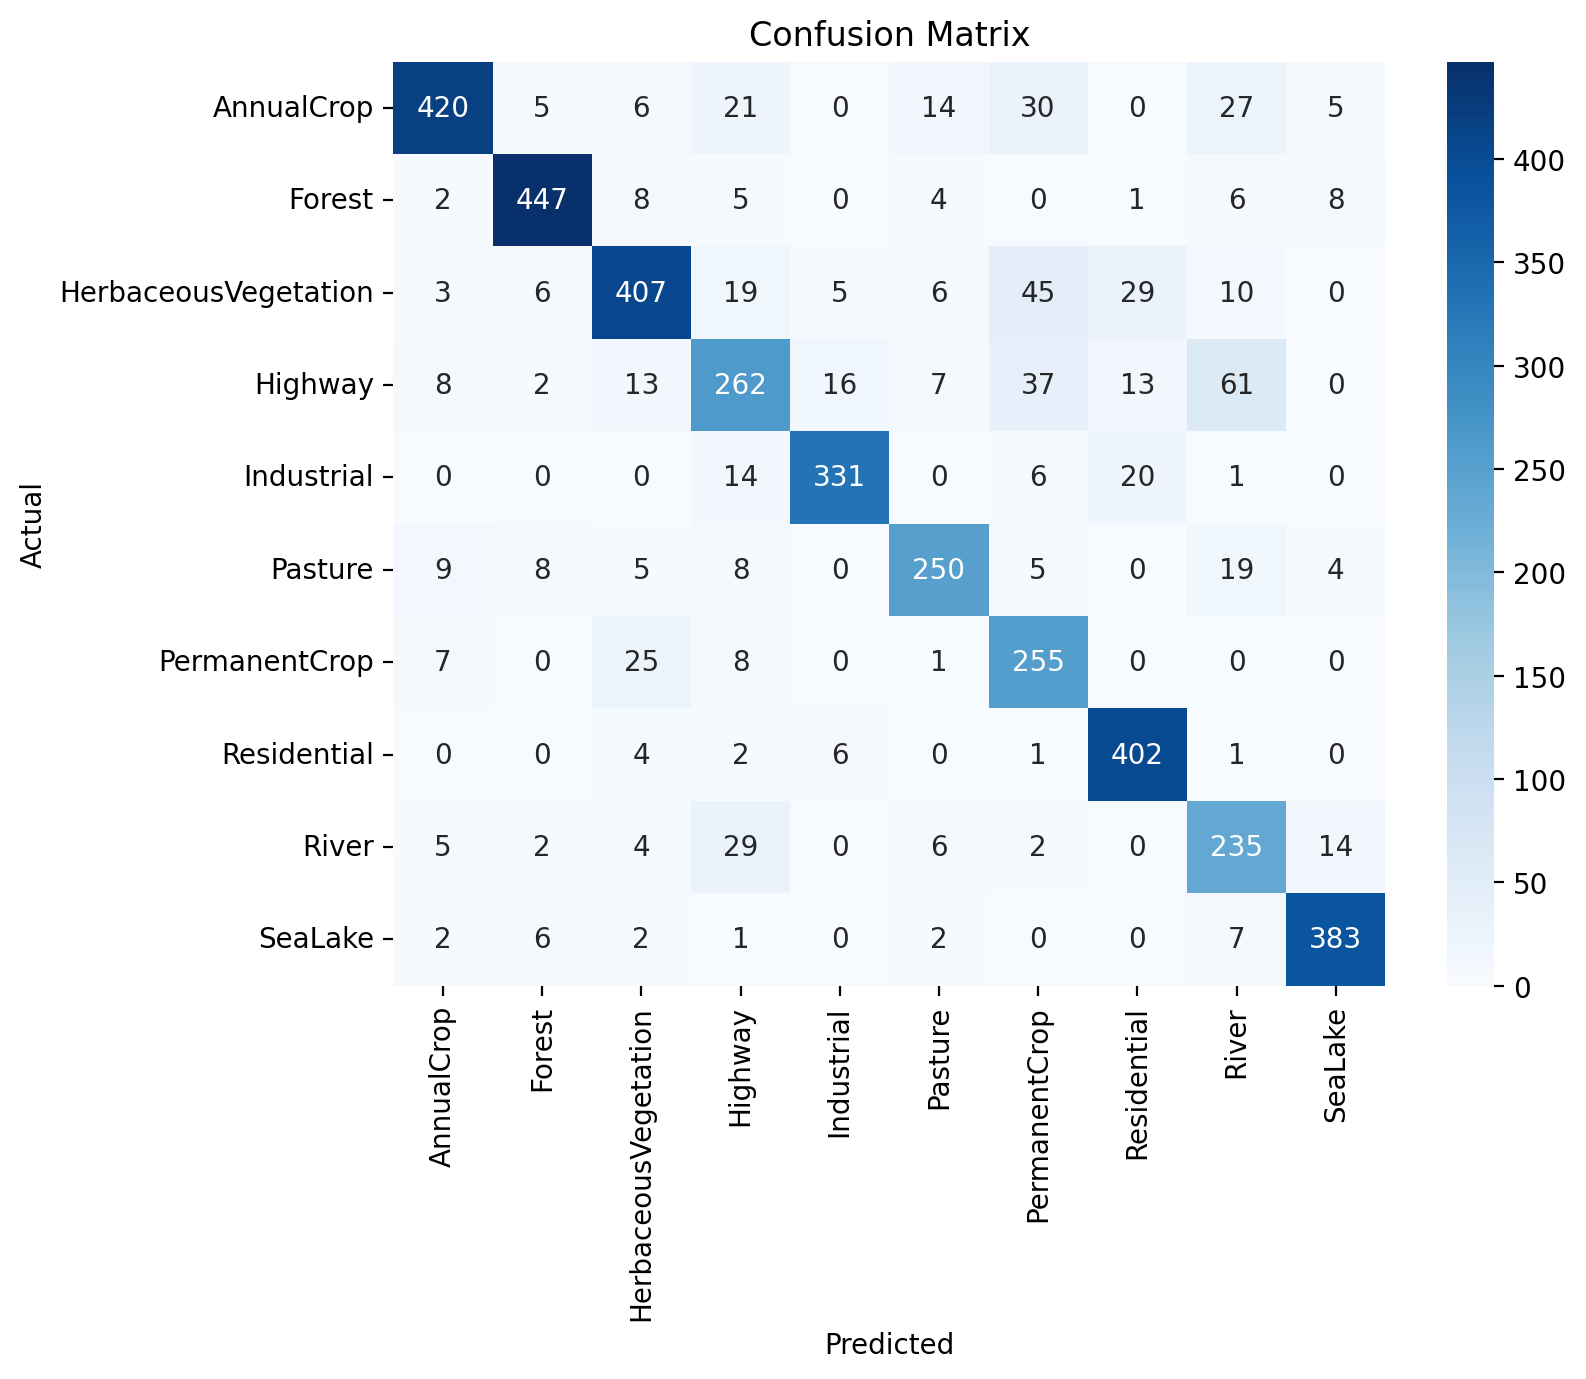

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.80      0.85       528
           1       0.94      0.93      0.93       481
           2       0.86      0.77      0.81       530
           3       0.71      0.63      0.66       419
           4       0.92      0.89      0.91       372
           5       0.86      0.81      0.84       308
           6       0.67      0.86      0.75       296
           7       0.86      0.97      0.91       416
           8       0.64      0.79      0.71       297
           9       0.93      0.95      0.94       403

    accuracy                           0.84      4050
   macro avg       0.83      0.84      0.83      4050
weighted avg       0.84      0.84      0.84      4050



In [136]:
metrics(all_predictions_int8,all_labels_int8)

# Model Size

In [137]:
import os
def print_model_size(mdl):
    torch.save(mdl.state_dict(), "tmp.pt")
    print("%.2f MB" %(os.path.getsize("tmp.pt")/1e6))
    os.remove('tmp.pt')

In [138]:
print("FP64 model size:",end='')
print_model_size(model_64)
print("FP32 model size:",end='')
print_model_size(model)
print("FP16 model size:",end='')
print_model_size(model_fp16)
print("INT8 model QAT size:",end='')
print_model_size(model_quantized_trained)
print("INT8 model PTQ size:",end='')
print_model_size(model_quantized_static)


FP64 model size:5.94 MB
FP32 model size:2.98 MB
FP16 model size:1.50 MB
INT8 model QAT size:0.84 MB
INT8 model PTQ size:0.78 MB
